### In this notebook we will see how to build and train a multi-label image classification.

## Import libraries

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
import os
import tarfile
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

## Import data

In [ ]:
# download the PASCAL 2007 dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imagelocal/pascal_2007.tgz"
download_url(dataset_url, '.')

100%|██████████| 1.64G/1.64G [01:41<00:00, 16.1MB/s]


In [ ]:
# Extract from archive
with tarfile.open('/content/pascal_2007.tgz', 'r:gz') as tar:
  tar.extractall(path='./data')

In [ ]:
data_dir = './data/pascal_2007'
train_dir = os.path.join(data_dir,'train')
df = pd.read_csv(os.path.join(data_dir,'train.csv'))
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [ ]:
print(len(df))
print(len(df[df['is_valid'] == False]))
print(len(df[df['is_valid'] == True]))

5011
2501
2510


## Dataset

In [ ]:
labels = {
    0: 'person',
    1: 'bird',
    2: 'cat',
    3: 'cow',
    4: 'dog',
    5: 'horse',
    6: 'sheep',
    7: 'aeroplane',
    8: 'bicycle',
    9: 'boat',
    10:'bus',
    11:'car',
    12:'motorbike',
    13:'train',
    14:'bottle',
    15:'chair',
    16:'diningtable',
    17:'pottedplant',
    18:'sofa',
    19:'tvmonitor'
}

In [ ]:
inv_labels = {v: k for k, v in labels.items()}

In [ ]:
def encode_label(label):
    target = torch.zeros(20)
    for l in str(label).split(' '):
        target[int(inv_labels[l])] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

In [ ]:
class PascalDataset(Dataset):
  '''PASCAL 2007 Dataset'''

  def __init__(self, df, data_dir, transform=None):
    self.data_dir = data_dir
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    filename = self.df.iloc[idx,0]
    labels = self.df.iloc[idx,1]
    image = Image.open(os.path.join(self.data_dir,filename))
    if self.transform:
      image = self.transform(image)
    return image, encode_label(labels)

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_tfms = T.Compose([
    T.Resize((224,224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
])

valid_tfms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
])

In [ ]:
train_df = df[df['is_valid'] == False].reset_index(drop=True)
val_df = df[df['is_valid'] == True].reset_index(drop=True)

### Dataset

In [ ]:
train_ds = PascalDataset(df=train_df, data_dir=train_dir,transform=train_tfms)
val_ds = PascalDataset(df=val_df, data_dir=train_dir,transform=valid_tfms)

In [ ]:
print(len(train_ds))
print(len(val_ds))

2501
2510


In [ ]:
def show_sample(img, target):
    plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))

Labels: person(0) bicycle(8)


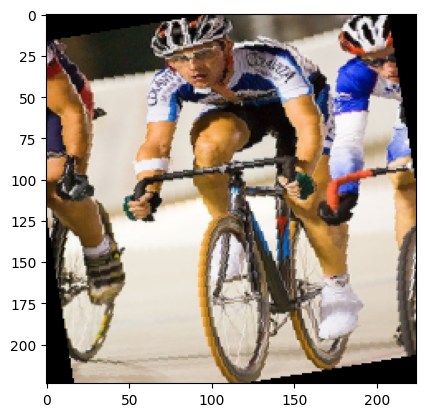

In [ ]:
show_sample(*train_ds[25])

### Dataloaders

In [ ]:
batch_size = 64

In [ ]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size*2, shuffle=False, num_workers=0, pin_memory=True)

In [ ]:
def show_batch(dl):
  for images, labels in dl:
      fig, ax = plt.subplots(figsize=(16, 8))
      ax.set_xticks([]); ax.set_yticks([])
      ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
      break

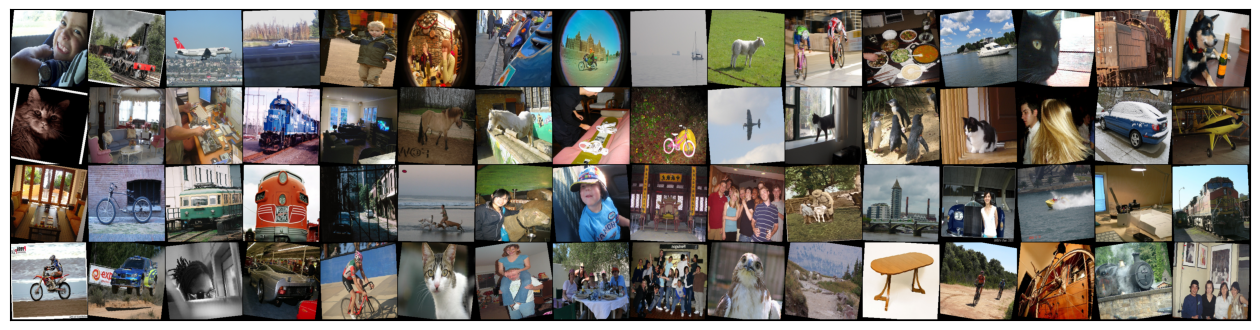

In [ ]:
show_batch(train_dl)

### Metrics

In [ ]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

## Model

In [ ]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch
        out = self(images)
        loss = F.binary_cross_entropy(out, targets)
        return loss

    def validation_step(self, batch):
        images, targets = batch
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets, threshold=0.2)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [ ]:
class PascalResnet(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 20)

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True

    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Training

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(PascalResnet(), device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 182MB/s]


In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 0.6982516050338745, 'val_score': 0.1450776308774948}]

In [ ]:
model.freeze()

In [ ]:
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.0075, train_loss: 0.2736, val_loss: 8.6756, val_score: 0.2945


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.0095, train_loss: 0.2548, val_loss: 0.3230, val_score: 0.2084


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.0061, train_loss: 0.2477, val_loss: 0.2580, val_score: 0.2725


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.0019, train_loss: 0.2410, val_loss: 0.2357, val_score: 0.3184


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.0000, train_loss: 0.2303, val_loss: 0.2289, val_score: 0.3508
CPU times: user 2min 1s, sys: 11.1 s, total: 2min 12s
Wall time: 2min 14s


In [ ]:
model.unfreeze()

In [ ]:
%%time
history += fit_one_cycle(epochs, 0.001, model, train_dl, val_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.0008, train_loss: 0.2293, val_loss: 0.2494, val_score: 0.3114


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.0010, train_loss: 0.2293, val_loss: 0.2498, val_score: 0.3085


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.0006, train_loss: 0.2234, val_loss: 0.2259, val_score: 0.3525


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.0002, train_loss: 0.2201, val_loss: 0.2222, val_score: 0.3660


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.0000, train_loss: 0.2147, val_loss: 0.2173, val_score: 0.3823
CPU times: user 2min, sys: 11.5 s, total: 2min 11s
Wall time: 2min 12s


In [ ]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');

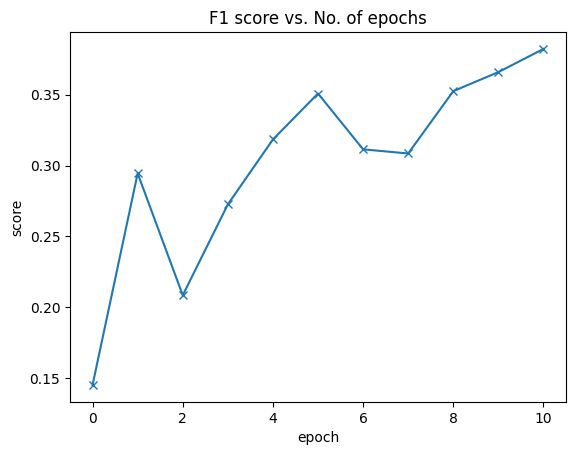

In [ ]:
plot_scores(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

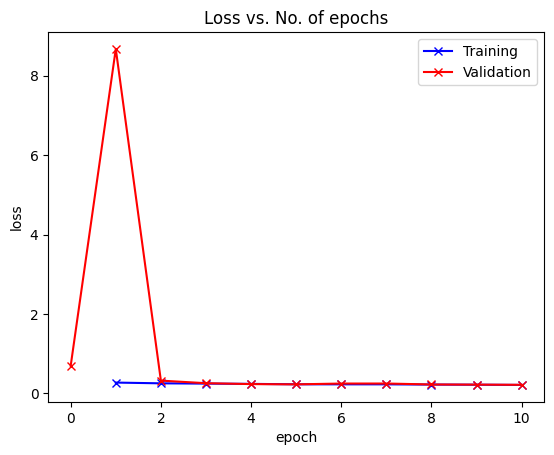

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

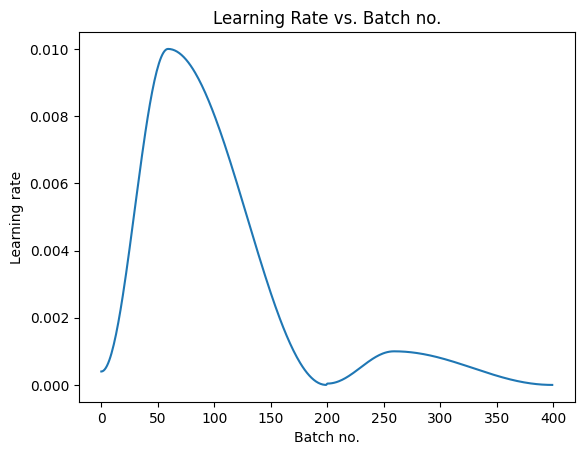

In [ ]:
plot_lrs(history)

## Inference

In [ ]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

In [ ]:
test_dir = os.path.join(data_dir, 'test')
test_df = pd.read_csv(os.path.join(data_dir,'test.csv'))
test_ds = PascalDataset(df=test_df, data_dir=test_dir,transform=valid_tfms)

In [ ]:
img, target = test_ds[0]
img.shape

torch.Size([3, 224, 224])

Prediction:  tensor([2.3173e-01, 3.1569e-03, 1.6224e-04, 5.3261e-03, 2.0115e-03, 1.0996e-02,
        5.9454e-04, 4.8898e-02, 3.1952e-02, 7.8307e-02, 1.4468e-01, 5.2898e-01,
        6.4119e-02, 3.2034e-01, 2.9644e-04, 2.8581e-03, 1.2444e-04, 4.1828e-03,
        1.3927e-03, 3.7434e-03], device='cuda:0', grad_fn=<SelectBackward0>)
Labels: car(11)


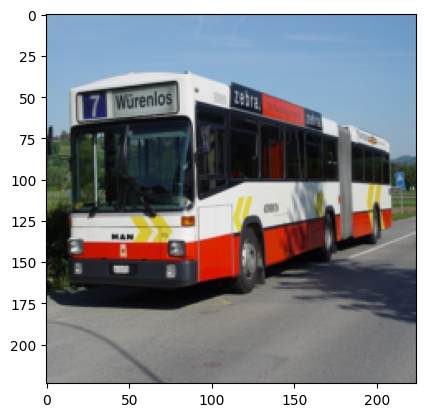

In [ ]:
predict_single(test_ds[25][0])